# Capture and treatment of satellite images

The module **tiff_downloader** is used to capture and process satellite images in an easy and convenient way. Additionally, it is possible to combine raster data with shapefiles layers to get more insightful images. The module **shapefile_module** is responsible for this part. We will be working with the file *RJ_Mun97_region.shp*, which can be downloaded at [this link](http://www.ipea.gov.br/ipeageo/malhas.html). This is the the map of the state *Rio de Janeiro*.

## 1. Extract information from the shapefile

When the module *tiff_downloader* is imported, it is likely that a browser window will open, showing an authentication message from Google Earth Engine. Besides that, if you intend to make a script to perform several downloads from Google Earth Engine, more browser windows will be opened. For this reason the function **download_tiffs** close all windows after the downloads are finished, so you don't need to worry about closing them manually.

On the other hand, if you intend to work on a notebook, using the browser, just set the option *close_browser* to *False*. The downside is that now you need to close the windows manually. The default is to close windows from Chrome running with Linux. To change this you can check the end of the function **download_tiffs** and (un)comment the lines that fit your purposes.

In [1]:
import glob
import os
import numpy as np
import rasterio
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from datetime import timedelta
from sqlalchemy import create_engine
import tiff_downloader as td
import shapefile_module as shpm

%matplotlib inline

/home/felipe/anaconda3/envs/satelite2/lib/python3.7/site-packages/datashader/transfer_functions.py:21: FutureWarning: xarray subclass Image should explicitly define __slots__
  class Image(xr.DataArray):


In [2]:
# Set the filepath and load in a shapefile.
shp_path = "RJ_Mun97_region/RJ_Mun97_region.shp"
map_df = gpd.read_file(shp_path)
map_df.head()

,CODMUN6,MUNIC_PIO,SEM_ACENTO,MUNIC_PI0,UF,UF_IBGE,REGI_O,MESO_IBGE,MESO_IBG0,MICRO_IBGE,MICRO_IB0,MESO_IBG1,MICRO_IB1,AREA_97,SEDE,SEDE0,N91,N96,CODCOMP,geometry
0,330380,PARATI,PARATI,330380,RJ,33,SE,SUL FLUMINENSE,05,BAIA DA ILHA GRANDE,013,3305,330513,928.4739,-44.713,-23.218,24525.0,1003699.0,330501303807,"POLYGON ((-44.88277 -23.20215, -44.88147 -23.2..."
1,330420,RESENDE,RESENDE,330420,RJ,33,SE,SUL FLUMINENSE,05,VALE DO PARAIBA FLUMINENSE,011,3305,330511,1113.4390,-44.447,-22.469,94307.0,93961.0,330501104201,"POLYGON ((-44.80918 -22.40462, -44.80739 -22.3..."
2,330225,ITATIAIA,ITATIAIA,330225,RJ,33,SE,SUL FLUMINENSE,05,VALE DO PARAIBA FLUMINENSE,011,3305,330511,224.9654,-44.563,-22.496,16711.0,21216.0,330501102254,"POLYGON ((-44.66073 -22.37775, -44.65937 -22.3..."
3,330411,PORTO REAL,PORTO REAL,330411,RJ,33,SE,SUL FLUMINENSE,05,VALE DO PARAIBA FLUMINENSE,011,3305,330511,50.6217,-44.290,-22.420,0.0,8664.0,330501104110,"POLYGON ((-44.33251 -22.49120, -44.34302 -22.4..."
4,330440,RIO CLARO,RIO CLARO,330440,RJ,33,SE,SUL FLUMINENSE,05,VALE DO PARAIBA FLUMINENSE,011,3305,330511,841.3873,-44.136,-22.723,13724.0,14449.0,330501104409,"POLYGON ((-44.32008 -22.84531, -44.31885 -22.8..."


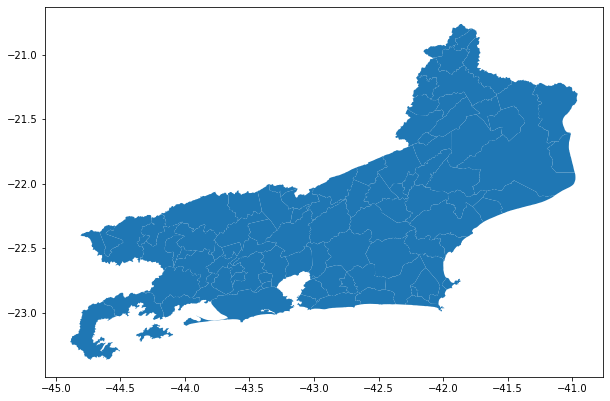

In [3]:
# Plot whole shapefile.
map_df.plot(figsize=[10,10])

In the module **shapefile_module** there is the function **extract_shp_boundingbox**, we use it to extract the bounding box of a shapefile. The outputs of this function are *point1* and *point2*, where *point1* is the top left point and *point2* is the bottom right point. These are spatial coordinates in the system epsg:4326. The program makes the change of coordinate automatically if the original shapefile is using another system so you don't need to worry about it.
This module always use the second column ('MUNIC_PIO' in this case) as labels for each one of the polygons. Thus we advise to use a shapefile such that the labels of the second column are all distinct between each other. Otherwise the program will encounter ambiguity, which may lead to errors.

In [4]:
# Extract bounding box from shapefile.
point1, point2 = shpm.extract_shp_boundingbox(shp_path)
print('point 1 =', point1)
print('point 2 =', point2)

point 1 = [-44.88834, -20.763056]
point 2 = [-40.957431, -23.367102]


## 2. Download and work with satelite images

The main function of the module **tiff_downloader** is called **download_tiffs**, and it has the following parameters as input: 

                    source, dates, point1, point2, opt
                    
 - *source* can be any one of the names mentioned when we call the function **about** with *sources* as input. For example 'LandDAAC-v5-day' is a valid source parameter. 
 
 - *dates* is the collection of dates (as timestamps) we are interested in. 
 
 - *point1* is a tuple (x, y), corresponding to the top left point of the image, while *point2* corresponds to the bottom right point. 
 - *opt* is a dictionary with all optional variables of interest. These variables are described in the function **about** with the argument *options*. If nothing is passed to *opt*, then the program just download the images in their original format. 

Below we show a example passing the option 'regrid' to get a bigger size (3 times bigger in each dimension), using the bilinear method and plotting the images on the screen. We choose to download the images from LandDAAC-v5-day, at the day 2016-jul-20.  

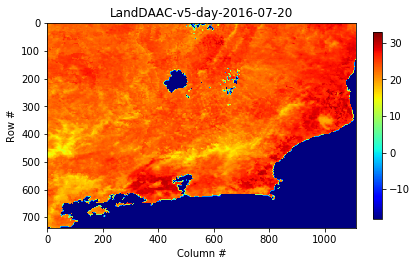

In [5]:
# Download raster data.
source = 'LandDAAC-v5-day'
dates = pd.date_range('2016-07-20', '2016-07-20')
options = {'plot': True, 'keep_original': True, 'regrid': [3, 'bilinear'], 'close_browser': False}

td.download_tiffs(source, dates, point1, point2, opt=options)

Some additional features are the following:

**1)** The colormap can be passed as an option inside the class of options. It must be a string with a valid colormap name. 

**2)** Sometimes you don't need to save the original files, only the treated ones. Instead of downloading them and deleting manually, you can just set the option *keep_original* to False. This parameter is part of the dictionary *options*. 

**3)** After all downloads are completed, it may be interesting to use some tool (here we use Geoviews) to interact with the time series. This is possible when the option *time_series* is set to True.

**4)** Maybe you want to visualize the time series of some data already in your computer. The default filename to be read by the program is *time_series.nc*. The function responsible for visualizing time series is called **view_time_series**, and you only need to pass the file name as argument. 

**5)** Plot the time series of individual points and average pixel per polygon.

**Attention:** to use interactivity the time interval must be within the same year, otherwise we have an error. This is a limitation of the interface for interactivity.  

We can combine the raster file just downloaded with the shapefile. To see how they match, we combine the first untreated raster file *LandDAAC-v5-day-2016-07-20.tiff* with the shapefile. In this example we assume all the downloaded files are in a folder called *DownloadedFiles*. The location where the downloaded files goes should be written in the file *settings.ini* (write the full path in this file).

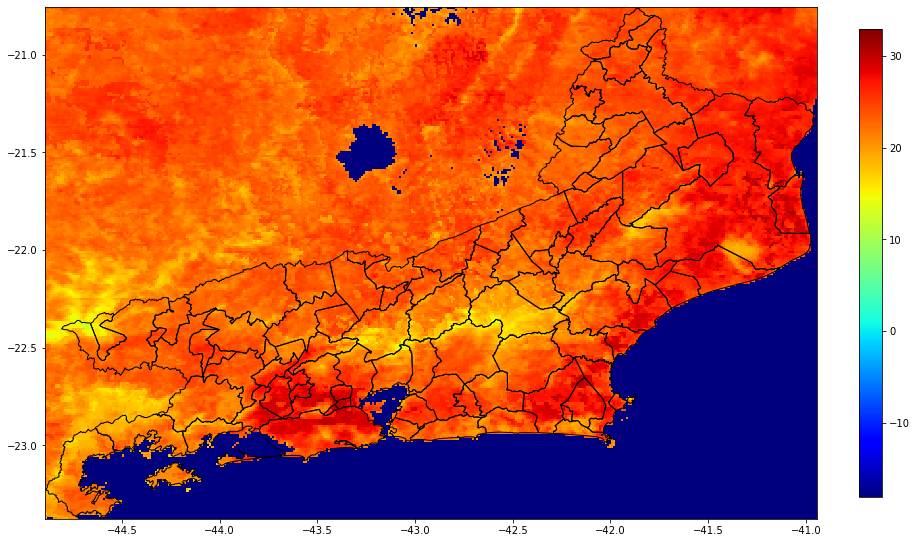

In [6]:
raster_path = "DownloadedFiles/LandDAAC-v5-day/LandDAAC-v5-day-2016-07-20.tiff"
shpm.raw_plot(shp_path, raster_path, cmap='jet')

Below we show the treated raster file *LandDAAC-v5-day-2016-07-20-treated.tiff* with the same shapefile. The difference is not so much noticeable since the image is already, but it is possible to note that the treated image is more smooth.

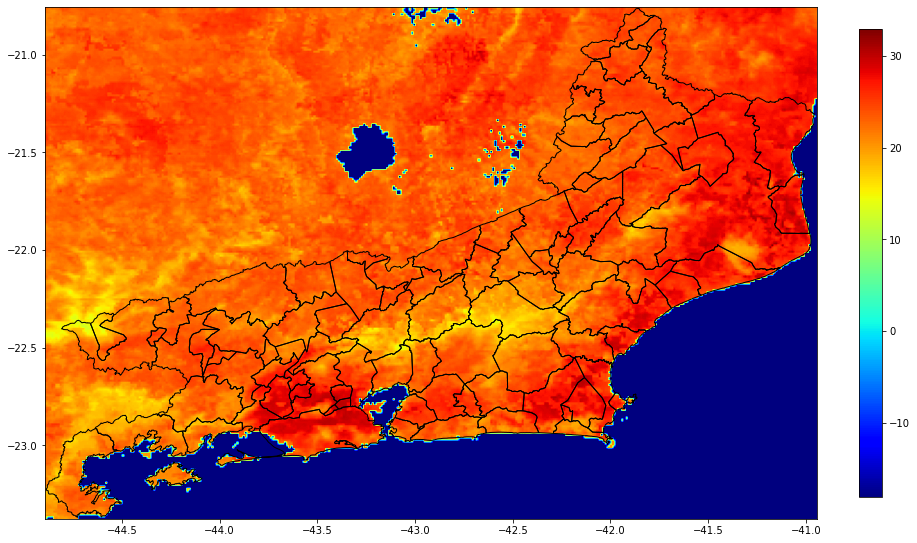

In [7]:
raster_path = "DownloadedFiles/LandDAAC-v5-day/LandDAAC-v5-day-2016-07-20-treated.tiff"
shpm.raw_plot(shp_path, raster_path, cmap='jet')

Now we want to compute the average pixel with respect to each polygon, i.e., the average of the pixels inside a polygon. After doing that for all polygons, we can make a new plot, showing only the colors of the respective averages. Here we change the colormap to *Reds* just for fun.

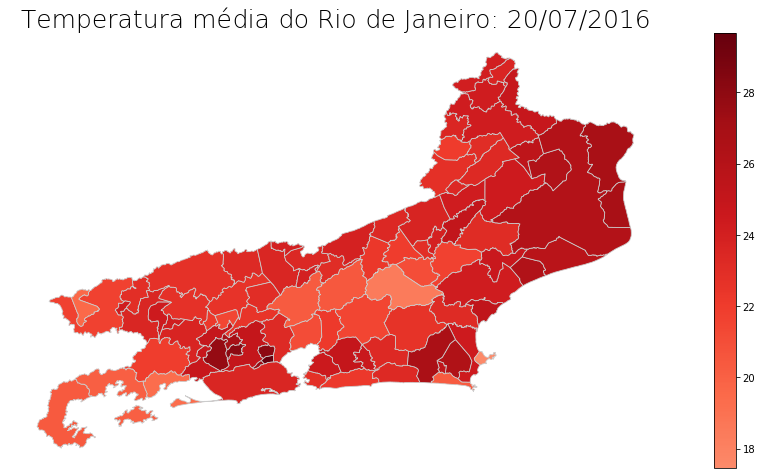

In [8]:
z_means = shpm.zonal_means(shp_path, raster_path)
shpm.zonal_plot(shp_path, z_means, 'Temperatura média do Rio de Janeiro: 20/07/2016', cmap='Reds')

## 3. Interactivity

It is possible to enable interactivity with Geoviews. For this we'll need to download several raster files in sequence. In this example we are downloading the land temperature at night from july-01 of 2016 to october-30 2016 with a frequency of 8 days (which is the frequency of the source *LandDAAC-v5-night*). 

To construct the time series, all files of the corresponding source folder within *DownloadedFiles* are merged. Thus it is necessary to leave that folder empty and to set *keep_original* to *False* before calling the function with *time_series = True*.

**Warning**: there are some [issues](https://github.com/pydata/xarray/issues/2535) between rasterio and NetCDF so I recommend to restart the kernel after using any function with interactivity.

In [9]:
# Download more files so we have a reasonable dataset to explore with Geoviews.
source = 'LandDAAC-v5-night'
dates = pd.date_range('2016-07-20', '2016-10-30', freq='8D')
point1, point2 = shpm.extract_shp_boundingbox(shp_path)
options = {'regrid': [3, 'cubic'], 'keep_original': False, 'time_series': True, 'close_browser': False}
    
td.download_tiffs(source, dates, point1, point2, opt=options)

The interactive display is opened right after the downloads are made. If for some reason you closed the notebook and want to use same interactivity again, call the function **view_time_series**. This function will read the time series (stored in the file *time_series.nc*) and reopen the interactive session.

In [ ]:
# Use the function 'view_time_series' to view any time series already downloaded.
td.view_time_series('DownloadedFiles/LandDAAC-v5-night/time_series.nc', cmap='inferno')

Since we are making several downloads, it is of interest to keep track of them so we don't waste time repeating the same downloads. All downloads are recorded in a database called *downloads.db* which can be consulted anytime. Furthermore, whenever a download request is made, the first action of the program is to access this database to be sure this is a new download. In the case of a repeated request, no download is performed.

In [17]:
engine = create_engine('sqlite:///downloads.db')
conn = engine.connect()
df = pd.read_sql_query("select * from DOWNLOADS", conn)
conn.close()
df.head()

,source,image_date,download_date,bounding_box,path
0,LandDAAC-v5-day,2016-07-20,2019-12-10,"[-44.88834, -20.763056][-40.957431, -23.367102]",/home/felipe/PycharmProjects/satelite/FGV_FioC...
1,LandDAAC-v5-day,2016-07-20,2019-12-10,"[-44.88834, -20.763056][-40.957431, -23.367102]",/home/felipe/PycharmProjects/satelite/FGV_FioC...
2,LandDAAC-v5-night,2016-07-20,2019-12-10,"[-44.88834, -20.763056][-40.957431, -23.367102]",/home/felipe/PycharmProjects/satelite/FGV_FioC...
3,LandDAAC-v5-night,2016-07-28,2019-12-10,"[-44.88834, -20.763056][-40.957431, -23.367102]",/home/felipe/PycharmProjects/satelite/FGV_FioC...
4,LandDAAC-v5-night,2016-08-05,2019-12-10,"[-44.88834, -20.763056][-40.957431, -23.367102]",/home/felipe/PycharmProjects/satelite/FGV_FioC...


## 4. Plots of time series

At each timestamp we have a raster file from which we can extract averages. In particular, one can choose some cities (polygons of the shapefile) and visualize the time series of its averages. The function **time_series** computes the sequence of averages (as showed with the function **zonal_plot**) for a certain polygon, which should be referred by its name in the second column of the shapefile. Below we show an example of usage of this function.

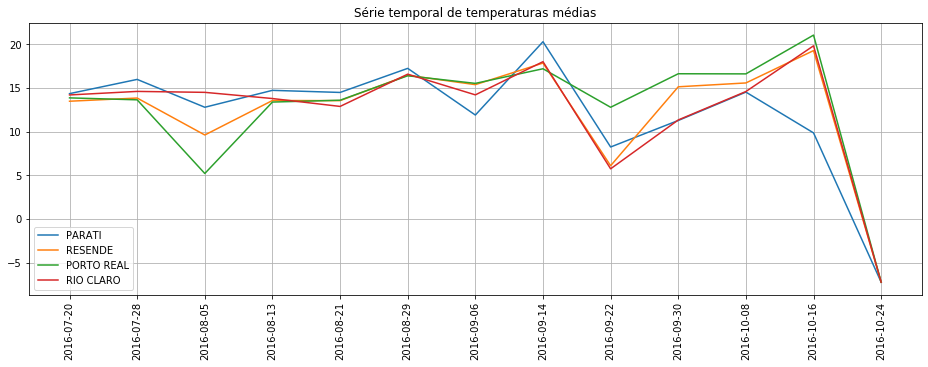

In [11]:
# Create list with all tiff filenames in alphabetical order.
filenames = glob.glob('DownloadedFiles/LandDAAC-v5-night/*.tiff')
filenames.sort()

# Create time series of some boroughs in the sequence of raster data 
t_series1, dates = shpm.time_series(shp_path, filenames, 'PARATI', plot=False)
t_series2, dates = shpm.time_series(shp_path, filenames, 'RESENDE', plot=False)
t_series3, dates = shpm.time_series(shp_path, filenames, 'PORTO REAL', plot=False)
t_series4, dates = shpm.time_series(shp_path, filenames, 'RIO CLARO', plot=False)

# Plot time series
plt.figure(figsize=[16, 5])
plt.plot(dates, t_series1, label='PARATI')
plt.plot(dates, t_series2, label='RESENDE')
plt.plot(dates, t_series3, label='PORTO REAL')
plt.plot(dates, t_series4, label='RIO CLARO')
title = 'Série temporal de temperaturas médias'
plt.title(title)
plt.legend()
plt.xticks(rotation=90)
plt.grid()
plt.show()

The function **point_time_series** plots the time series evolution with respect to the row-column coordinate of the array image. 

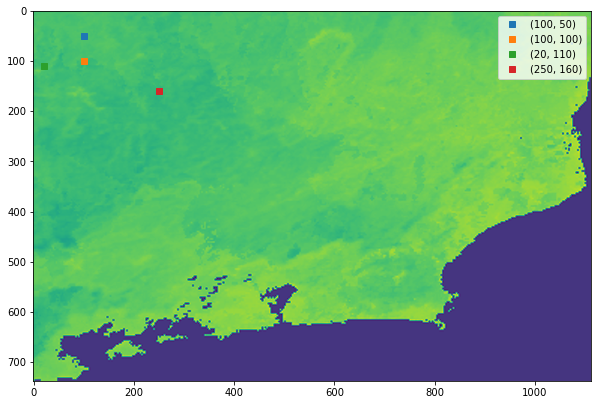

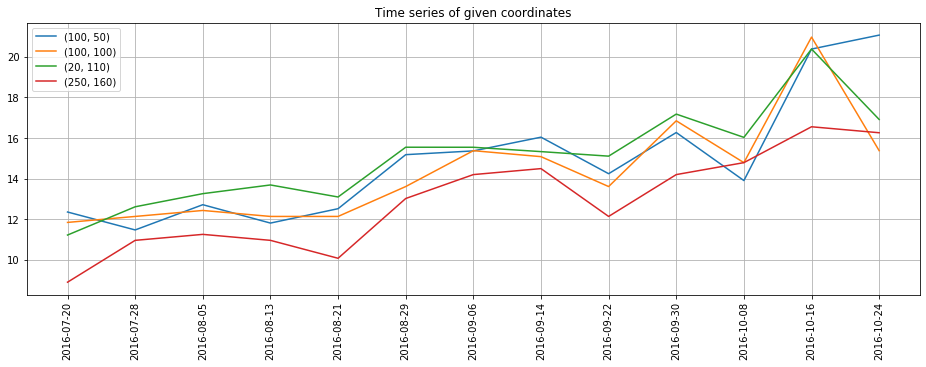

In [12]:
points = [[100, 50], [100, 100], [20, 110], [250, 160]]
info = td.point_time_series(source, points, spatial_coordinates=False)

If desired, it is possible to pass spatial coordinates to the function. In this case set the optional parameter 'spatial_coordinates' to True. One can make the same plot using spatial coordinates instead. 

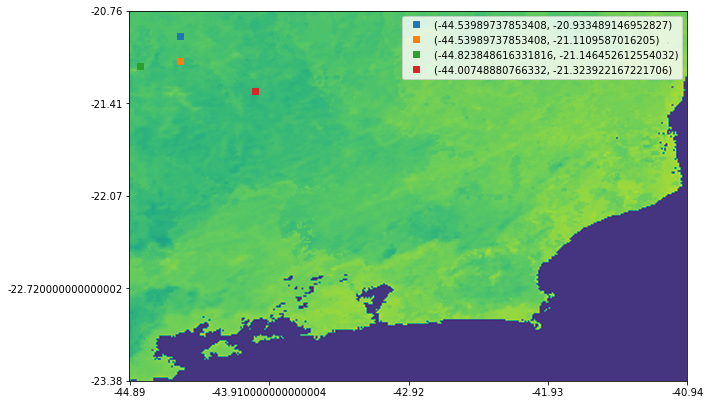

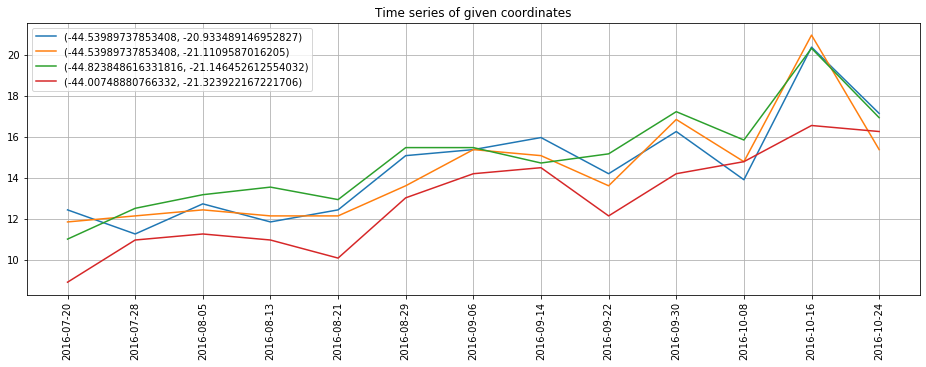

In [13]:
data = rasterio.open("DownloadedFiles/LandDAAC-v5-night/LandDAAC-v5-night-2016-07-20-treated.tiff")
points = [data.transform * [100, 50], 
         data.transform * [100, 100], 
         data.transform * [20, 110], 
         data.transform * [250, 160]]

info = td.point_time_series(source, points, spatial_coordinates=True)

# 5. Dark Sky

[Dark Sky](https://darksky.net) is an online weather API easy to manipulate. Unlike the other functionalities showed here, you can't download satellite images from Dark Sky. On the other hand, we have access to coordinate wise data, which is useful if one is just interested in taking time series or any kind of numerical data. For instance, instead of downloading the entire raster file from some city and computing the average temperature (by taking the mean of all pixels of that city), with Dark Sky we can just download the data from the centroid of the city. This data may be considered as a representative of the city. This approach is less precise but much faster.

Suppose we are interested in studying the humidity of the city of Rio de Janeiro from 2019-01-01 to 2019-06-01, taking weekly intervals.

In [18]:
# Set date range.
dates = pd.date_range('2019-01-01', '2019-06-01', freq='7D')

# Extract centroid from shapefile.
rio_de_janeiro = map_df[map_df['MUNIC_PIO'] == 'RIO DE JANEIRO']
centroid = rio_de_janeiro.geometry.centroid.values[0]
x, y = centroid.x, centroid.y

# Not the real key.
key = '352adedf830f6bd1d61a343f7a2d732'

# Call function.
td.darksky(dates, x, y, key)

All data is saved in a local database called *downloads_darksky.db*. Here we show the first lines of this database. Note that, although we are only interested in the humidity information, there are other information to be used. In fact, the original downloads have even more but for our purposes these are enough. 

In [5]:
engine = create_engine('sqlite:///downloads_darksky.db')
conn = engine.connect()
df = pd.read_sql_query("select * from DOWNLOADS", conn)
conn.close()
df.head()

,date,download_date,latitude,longitude,precipIntensity,humidity,temperatureMin,temperatureMax
0,2019-01-01,2019-12-10,-43.477583,-22.930582,0.0076,0.88,50.26,57.72
1,2019-01-08,2019-12-10,-43.477583,-22.930582,0.0201,0.93,55.47,58.08
2,2019-01-15,2019-12-10,-43.477583,-22.930582,0.0013,0.77,51.88,56.71
3,2019-01-22,2019-12-10,-43.477583,-22.930582,0.0181,0.91,55.67,61.31
4,2019-01-29,2019-12-10,-43.477583,-22.930582,0.0077,0.76,49.77,59.39


## 6. Making animations with time series

Sometimes it may be more interesting to visualize a time series as an animation. Here we show how to use our program to make nice animations with little effort. 

### 6.1 Curve animations
Now we download the *LST_Day_1km* data from Google Earth Engine.

In [14]:
# Download LST data. 
source1 = 'LST_Day_1km'
options = {'close_browser': False}
td.download_tiffs(source1, dates, point1, point2, opt=options)

ERROR:root:Download (2019-03-12): failure (Unexpected Error)


In the case some file couldn't be downloaded, the program keep trying to make the download 15 times (for 15 minutes) before giving up, so repeating all over again won't solve the problem. A work around to this problem is to generate the missing data using interpolation. We only need to specify what source has missing data and the frequency we want to fill these data. The parameter *treated* tells the program if we want to consider only the treated data or not.

In [15]:
# Use interpolation to fill the gaps.
source = 'LST_Day_1km'
freq = '7D'
td.fill_missing_days(source, freq, treated=False)

Repeat the procedure for the CHIRPS data.

In [16]:
# Download rainfall data.
source = 'CHIRPS'
options = {'close_browser': False}
td.download_tiffs(source, dates, point1, point2, opt=options)

Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?client_id=517585324241-6igjjnaai2c2rid8dm5071l6k2gbl6j2.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8080%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&access_type=offline&response_type=code

Authentication successful.


In [20]:
# Use interpolation to fill the gaps.
source = 'CHIRPS'
freq = '7D'
td.fill_missing_days(source, freq, treated=False)

All the raster files are downloaded to the same folder which we called *DownloadedFiles* here (you should set your own download path in th file *settings.ini*). After that we separate the files into two folders: *lst* and *rainfall*. This is not necessary but it keep everything more organized. All the paths to the files are stored in the lists *lst_paths* and *rainfall_paths*, respectively.

Notice that some of the LST downloads failed, and we need this data to make the animation. There are lots of ways to deal with this missed data, and here we choosed the simple strategy of just copying the last successful download. 

In [7]:
# For each date we can construct a dataframe with the average pixel for region. 
# We storage these dataframes in dictionaries with the dates as keys. 
lst_path_base = 'DownloadedFiles/LST_Day_1km/LST_Day_1km-'
lst_paths = []
for i in range(len(dates)-1):
    date = dates[i].strftime("%Y-%m-%d")
    lst_path = lst_path_base + date + '.tiff'
    lst_paths.append(lst_path)

In [8]:
# Repeat the same procedure for the rainfall data.
rainfall_path_base = 'DownloadedFiles/CHIRPS/CHIRPS-'
rainfall_paths = []
for i in range(len(dates)-1):
    date = dates[i].strftime("%Y-%m-%d")
    rainfall_path = rainfall_path_base + date + '.tiff'
    rainfall_paths.append(rainfall_path)

Now we join both lists in a list called *raster_paths*. This list gives pointers to the raster files of interest. 

In [9]:
# Make list from the lists of paths.
raster_paths = [lst_paths, rainfall_paths]

Not all data in the animation must be a downloaded raster data, you can use external data. They must by Numpy 1D arrays such that each row correspond to the value of a specific date. The ordering of the rows must follow the same chronological order of the raster files. As external data we will use the humidity data downloaded from Dark Sky.

In [10]:
humidity = df['humidity'].values[:-1]

Finally, we call the function **time_series_curve**, which saves the time series as an animation in the current working directory. To see what each options does, see the documentation.

In [11]:
title = 'RIO DE JANEIRO: '
region = 'RIO DE JANEIRO'
labels = ['LST', 'RAINFALL', 'HUMIDITY']
save_path = 'DownloadedFiles/'
shpm.time_series_curve(shp_path, raster_paths, save_path, region, title, labels, extra_data=[humidity], norm=True, framerate=0.7, figsize=[18, 8])

![curve](readme_files/curve.gif "curve")

### 6.2 Map animations

The previous kind of animation when we want to focus on a single region and see several different information of this region at the same time. But sometimes we want to see the big picture. How is this region compared to the others? It is possible to address this question but we need to restrict ourselves to just one feature at time. To illustrate the steps we use the LST data downloaded before.

Remember the last plot in section 2, where we made the plot of the average temperature per city of all state of Rio de Janeiro in 2016-07-20. Instead of having the picture of just one day, we can make a series of the same kind of plot. For this we need to transform all LST raster data (downloaded previously) into a single dataframe, where each index correspond to a city and each columns correspond to a date. We can use the function **zonal_means** to accomplish this with little effort, as showed below.

In [12]:
# Construct list with all the arrays of the averages, one for each day.
lst_array_list = []
for i in range(len(lst_paths)):
    z_means = shpm.zonal_means(shp_path, lst_paths[i])
    lst_array_list.append(z_means.values)

In [13]:
# Transform this list into a single dataframe.
lst_df = pd.DataFrame(np.concatenate(lst_array_list, axis=1), index=z_means.index)

# We must change the column labels to the actual dates. If the column labels are not timestamps then 
# we get an error. The last date in dates is never used because we made the downloads in intervals, 
# storing only the first date of the interval.
lst_df.columns = dates[:-1]
lst_df.head()

,2019-01-01,2019-01-08,2019-01-15,2019-01-22,2019-01-29,2019-02-05,2019-02-12,2019-02-19,2019-02-26,2019-03-05,...,2019-03-19,2019-03-26,2019-04-02,2019-04-09,2019-04-16,2019-04-23,2019-04-30,2019-05-07,2019-05-14,2019-05-21
PARATI,28.009751,27.581762,28.263106,29.140239,28.508105,25.756488,27.225729,22.596191,22.596191,26.635297,...,23.730996,24.309451,23.042969,24.090472,23.996750,23.996750,21.976946,23.410824,19.882823,20.476499
RESENDE,28.787097,29.004639,29.708387,30.157159,29.024656,26.381946,29.299608,25.443571,25.443571,27.268334,...,24.704887,25.039971,23.800100,25.702462,24.757151,24.757151,23.959478,23.808652,18.345909,22.390573
ITATIAIA,26.295843,26.870102,28.156660,27.976742,26.999193,24.660552,28.042360,26.532602,26.532602,25.013636,...,22.670490,23.739499,22.263318,23.887263,23.063933,23.063933,21.899171,21.251961,15.585421,21.026670
PORTO REAL,32.492252,33.007117,34.068649,33.525405,31.895495,30.532595,31.840180,26.532602,26.532602,30.623694,...,28.528919,28.042162,23.418333,28.705225,27.662432,27.662432,27.843514,27.718649,22.929910,24.992072
RIO CLARO,29.284227,28.244635,30.320452,30.753878,30.232222,25.732928,28.516759,24.216283,24.216283,27.427102,...,24.252413,23.874096,23.890996,24.425109,24.574450,24.574450,23.867137,23.442699,19.909131,22.407315


The important data you should have is this last dataframe and the shapefile. The procedure we conducted here to produce this dataframe is just an example, but feel free to produce it in other ways.

In [17]:
# Make the index of map_df to be the names of the regions.
map_df = map_df.set_index('MUNIC_PIO')

# Now we can create the animated map.
title = 'Temperatura média do Rio de Janeiro: '
shpm.time_series_map(map_df, lst_df, save_path, title, framerate=0.5, cmap='Reds')

![map](readme_files/map.gif "map")

## 7. Learning about the sources and options

Call the function **about**, first with the input 'sources', and them with the input 'options'. This function shows the relevant information about all the sources and options we have at our disposal.

In [18]:
td.about('sources')

LandDAAC-v5-day
---------------
Day LST from USGS LandDAAC MODIS 1km 8day version_005 Terra SSA: Day and Night Land Surface Temperature of Southern South America.
Time: grid: /T (days since 2003-01-01) ordered [ (5-12 Mar 2000) (13-20 Mar 2000) (21-28 Mar 2000) ... (22-29 Mar 2017)] N= 785 pts :grid
Longitude: grid: /X (degree_east) ordered (77.99467W) to (40.002W) by 0.01064817 N= 3569 pts :grid
Latitude: grid: /Y (degree_north) ordered (20.00532S) to (56.99707S) by 0.01064817 N= 3475 pts :grid
Link: https://iridl.ldeo.columbia.edu/SOURCES/.USGS/.LandDAAC/.MODIS/.1km/.8day/.version_005/.Terra/.SSA/.Day/.LST/

LandDAAC-v5-night
-----------------
Night LST from USGS LandDAAC MODIS 1km 8day version_005 Terra SSA: Day and Night Land Surface Temperature of Southern South America.
Time: grid: /T (days since 2003-01-01) ordered [ (5-12 Mar 2000) (13-20 Mar 2000) (21-28 Mar 2000) ... (22-29 Mar 2017)] N= 785 pts :grid
Longitude: grid: /X (degree_east) ordered (77.99467W) to (40.002W) by 0.010

In [19]:
td.about('options')

cmap (string)
-------------
The name of the colormap to use when plotting images. Default is `jet`.

regrid (list)
-------------
When downloading the images you also have the option to make a downsampling or upsampling over all the images and download these new pack of images. You should pass a list of two items. The first is a positive float, the ratio of the regrid. For example, if the original image is 120x120 and regrid[0]=2, them the program will create a image of shape 240x240. The second is the method of the resampling, which can be `nearest`, `average`, `bilinear` and `cubic`.
Link: https://github.com/mapbox/rasterio/blob/master/rasterio/enums.py#L28

plot (bool)
-----------
When this option is set to True the program plots each one of the images downloaded. At the moment this only works when some regrid is done. Default is False.

keep_original (bool)
--------------------
When this option is set to True (default) the program stores the original files. When it is False, the pro